In [274]:
import pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns

from PIL import Image
import skimage
from skimage.metrics import structural_similarity as ssim
import urllib.request

### Traits from player data
 
Player data here:

https://docs.google.com/spreadsheets/d/1oaO1E-QgHjw3qLCJBU71bgQKsReGJhHHttt-zQY8kLs/edit#gid=491689579

Upload results to csv here:

https://docs.google.com/spreadsheets/d/1JLXogbowRiISc4WN4YvnH_H5Eot3-vDpDaq5KJF71D8/edit#gid=0

In [220]:
d=pd.read_csv('baller_stats_updated.csv')
d.set_index('ID',inplace=True)

In [268]:
# Body (9700 total)
body_count =  d.groupby('Body').size()
body_frequency = body_count / body_count.sum()

# Hair (9700 total)
hair_count = d.groupby('Hair').size()
hair_frequency =  hair_count / hair_count.sum()

# Role (9700 total)
role_count = d.groupby('Role').size()
role_frequency =  role_count / role_count.sum()

# Accessories (12592 total)
def strip_ln(x):
    
    try:
        return x.strip()
    except AttributeError:
        return None
       
acc_count=d['Accessories'].str.split(',', expand=True).apply(lambda x: [strip_ln(e) for e in x]).stack().value_counts().sort_values(ascending=True)
acc_frequency=acc_count/acc_count.sum()

# Score (% observations that are below / less)
d['Overall']=d[['Dunks','Shooting','Playmaking','Defense']].mean(axis=1)
ranks = d['Overall'].rank(method = 'min')
maxi = ranks.size
d['Top_pct_performance'] = 1-(ranks-1)/maxi

Text(0, 0.5, 'Count')

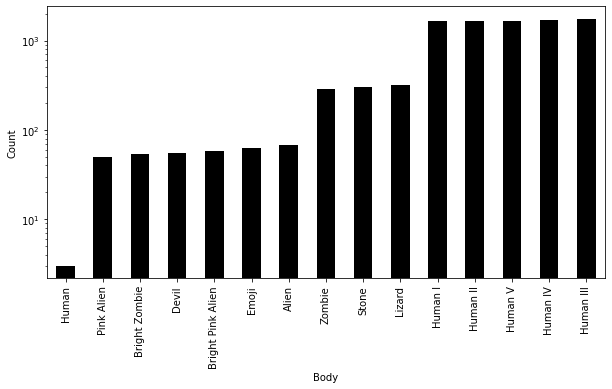

In [223]:
body_count.sort_values(ascending=True).plot.bar(logy=True,color='k',figsize=(10,5))
plt.xlabel('Body')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

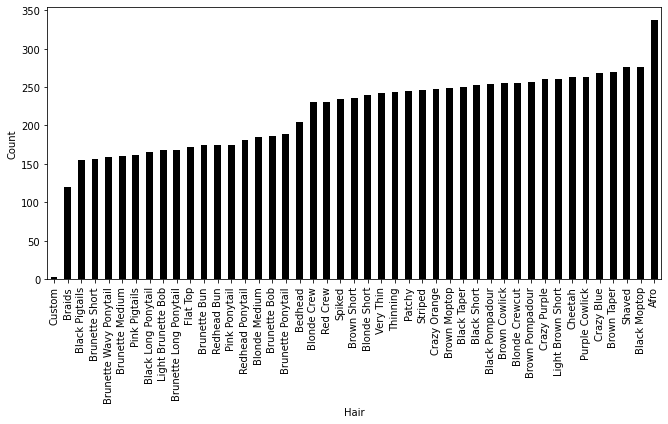

In [224]:
hair_count.sort_values().plot.bar(color='k',figsize=(11,5))
plt.ylabel('Count')

Text(0, 0.5, 'Count')

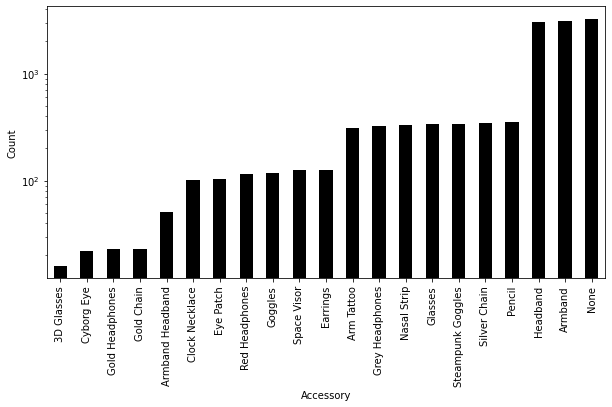

In [226]:
acc_count.sort_values(ascending=True).plot.bar(logy=True,color='k',figsize=(10,5))
plt.xlabel('Accessory')
plt.ylabel('Count')

In [269]:
# Unpack accessory data 
acc_data=pd.DataFrame(d['Accessories'].str.split(',', expand=True).apply(lambda x: [strip_ln(e) for e in x]))
acc_data.columns=['Acc1','Acc2','Acc3']
acc_data[['Acc2','Acc3']]=acc_data[['Acc2','Acc3']].fillna(0)

# Accessory frequency
def acc_freq(x):
    try:
        return acc_frequency.loc[x]
    except:
        return 0
    
acc_data['Acc1_freq']=acc_data['Acc1'].apply(lambda x: acc_freq(x))
acc_data['Acc2_freq']=acc_data['Acc2'].apply(lambda x: acc_freq(x))
acc_data['Acc3_freq']=acc_data['Acc3'].apply(lambda x: acc_freq(x))

# Get accessory frequency 
def mult_freq(a,b,c):
    arr=np.array([a,b,c])
    arr=arr[arr>0]
    return np.prod(arr)
    
acc_data['Acc_frequency']=acc_data.apply(lambda row: mult_freq(row['Acc1_freq'],
                                                          row['Acc2_freq'],
                                                          row['Acc3_freq']),axis=1)

In [270]:
# Join accessory 
d_join=d[['Body','Team','Jersey','Hair','Role','Number','Dunks','Shooting','Overall','Playmaking','Defense','Title','Top_pct_performance']]
all_f=pd.concat([acc_data,d_join],axis=1)

In [271]:
# Comppute hair, body, role frequency
def hair_freq(x):

    return hair_frequency.loc[x]

    
def body_freq(x):

    return body_frequency.loc[x]

def role_freq(x):

    return role_frequency.loc[x]

all_f['Body_frequency']=all_f['Body'].apply(lambda x: body_freq(x))
all_f['Hair_frequency']=all_f['Hair'].apply(lambda x: hair_freq(x))
all_f['Role_frequency']=all_f['Role'].apply(lambda x: role_freq(x))

In [272]:
# Finalize data
l=['Body','Body_frequency','Hair','Hair_frequency','Role','Role_frequency',
   'Acc1','Acc1_freq','Acc2','Acc2_freq','Acc3','Acc3_freq','Acc_frequency','Top_pct_performance']
all_f_trim=all_f[l].copy()
all_f_trim['Overall_rarity']=all_f_trim['Body_frequency']*all_f_trim['Hair_frequency']*all_f_trim['Acc_frequency']*all_f_trim['Role_frequency']
all_f_trim.replace(0, '', inplace=True)
all_f_trim.sort_values('Overall_rarity',ascending=True,inplace=True)
all_f_trim.to_csv('BALLERZ_rank.csv')

### Traits from image analysis

Not released formally by the team

In [ ]:
# Sort by ID
ballerz_sorted=all_f_trim.sort_index()

# For storing data
d_store_images = pd.DataFrame()

In [ ]:
# Fetch image data from IPFS
# Note: files saved locally to /var (on Mac, at least)

def get_img(ix):

    img=all_f_trim.loc[ix,'Image url'].split('//')[1]
    img_url="https://ipfs.io/ipfs/%s"%img
    img_path_local=urllib.request.urlretrieve(img_url)[0]
    return img_path_local
         
for ix in ballerz_sorted.index:
    
    d_store_images.loc[ix,'Img']=get_img(ix) 
    # Required to avoid HTTP 429
    time.sleep(1)
    
# Store locally b/c this takes a while (load from file in the future)
d_store_images.to_csv("your/local/path")

In [ ]:
# Check cropping
def plt_one_baller(ix):
    
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(5,5))
    img=all_f_trim.loc[ix,'Image url'].split('//')[1]
    img_url="https://ipfs.io/ipfs/%s"%img
    g=urllib.request.urlretrieve(img_url)
    img = mpimg.imread(g[0])
    imgplot = plt.imshow(img)
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)
    plt.title('BALLERZ ID: #%s'%ix)
    plt.axis('off')
    return img

def crop_grill(ix):
    
    im = Image.open(ix)
    # Trial and error param to crop only the grill
    c_crop = im.crop((159.5, 
                      height / 1.885, 
                      200.5, 
                      3 * height / 5.05))
    return c_crop

to_check = 2623
plt_one_baller(to_check)
crop_grill(d_store_images.loc[to_check,'Img'])

In [ ]:
# Player with grill to compare other against
postive_cntl_grill=get_img(2623)
postive_cntl_grill_crop=crop_grill(postive_cntl_grill)

def check_similarity(fx,seed,img_path):
    
    image_crop = fx(img_path)
    
    # Structural similarity between two images 
    sim = ssim(np.array(seed), 
               np.array(image_crop),
               multichannel=True)
    
    return sim

# Score for each image
d_store_images['Grill score']=d_store_images['Img'].apply(lambda x: check_similarity(crop_grill,
                                                                                     postive_cntl_grill_crop,
                                                                                     x))

In [ ]:
# Extract players with grillz
grillz=d_store_images[d_store_images['Grill score'] > 0.95]
print(grillz.shape)